# 1. "A quantidade de pedido mensal segue um padrão sazonal"

## Importação de bibliotecas

In [1]:
from scipy import stats
import scipy
import scipy.fftpack

import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

## Leitura dos dados

In [2]:
orders = pd.read_csv("../datasets/trusted/delivered_orders.csv")
orders.count()

Unnamed: 0                       93011
order_id                         93011
customer_id                      93011
order_approved_at                92997
order_purchase_timestamp         93011
order_estimated_delivery_date    93011
order_delivered_carrier_date     93009
order_delivered_customer_date    93003
dtype: int64

In [3]:
purchase_time = pd.to_datetime(orders['order_purchase_timestamp'])

orders_by_year_and_month = pd.DataFrame({
        'id': orders['order_id'],
        'time': pd.to_numeric(purchase_time),
        'year': purchase_time.dt.year,
        'month': purchase_time.dt.month,
        'day': purchase_time.dt.day,
})
orders_by_year_and_month.count()

id       93011
time     93011
year     93011
month    93011
day      93011
dtype: int64

## Análise por mês

A hipótese era de que haveria um padrão sazonal entre a quantidade de compras por mês no ano.


### Método

Dividimos os dados por mês, para ter uma visão geral da quantidade de compras mensal ao longo do ano.

Para ter uma noção mais relevante da sazonalidade dos dados, usamos [Transformadas de Fourier](https://pt.wikipedia.org/wiki/Transformada_de_Fourier) para encontrar as frequências mais relevantes no conjunto de dados.

Para isso aplicamos a função [`np.fft.rfft`](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.fft.rfft.html) do NumPy, que usa Fast Fourier Transform em sequências reais 1-D e elimina informações redundantes (simetria).

#### Sazonalidade dentro do ano

Aqui consideramos cortar os dados para olhar apenas os meses entre Janeiro e Agosto, porque 2018 não tem dados além disso. Chegamos à conclusão, porém, de que usar mais dados em 2017 não afeta a análise.

In [4]:
valid_on_both_years = orders_by_year_and_month #[orders_by_year_and_month['month'] <= 8]

sales_by_month = valid_on_both_years.groupby(['year', 'month']).agg(['count']).reset_index()
sales_by_month.describe()

,year,month,id,time,day
,,,count,count,count
count,20.000000,20.000000,20.000000,20.000000,20.000000
mean,2017.400000,5.700000,4650.550000,4650.550000,4650.550000
std,0.502625,3.278318,1944.153191,1944.153191,1944.153191
min,2017.000000,1.000000,731.000000,731.000000,731.000000
25%,2017.000000,3.000000,3339.000000,3339.000000,3339.000000
50%,2017.000000,5.500000,4842.500000,4842.500000,4842.500000
75%,2018.000000,8.000000,6424.500000,6424.500000,6424.500000
max,2018.000000,12.000000,7070.000000,7070.000000,7070.000000


In [5]:
sales_2017 = sales_by_month[sales_by_month['year'] == 2017]['id']['count']

fourier_2017 = np.abs(np.fft.rfft(sales_2017))
fourier_2017

array([42119.        ,  9213.03292432,  6815.17255834,  5811.77399767,
        4628.01004753,  1892.81862189,   857.        ])

In [6]:
sales_2018 = sales_by_month[sales_by_month['year'] == 2018]['id']['count']

fourier_2018 = np.abs(np.fft.rfft(sales_2018))
fourier_2018

array([50892.        ,  1652.65748583,   837.0818359 ,   302.81221003,
        1122.        ])

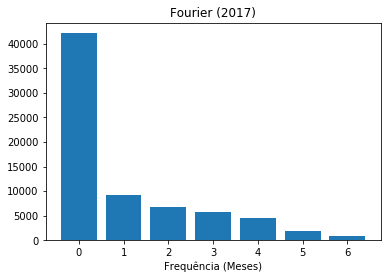

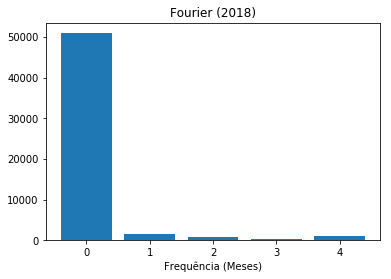

In [7]:
plt.bar(range(len(fourier_2017)), fourier_2017)
plt.title("Fourier (2017)")
plt.xlabel("Frequência (Meses)")
plt.show()

plt.bar(range(len(fourier_2018)), fourier_2018)
plt.title("Fourier (2018)")
plt.xlabel("Frequência (Meses)")
plt.show()

In [8]:
print(stats.kruskal(fourier_2017, fourier_2018).pvalue * 100, "%", sep='')

16.746459631208534%


Como a frequência mais relevante dada pelo Fourier em ambos os anos é 0, podemos deduzir que não existe sazonalidade dentro de um ano, ou que ela é praticamente nula.

#### Sazonalidade mensal

In [9]:
sales_by_month = orders_by_year_and_month.groupby(['year', 'month']).agg(['count']).reset_index()
sales_by_month.describe()

,year,month,id,time,day
,,,count,count,count
count,20.000000,20.000000,20.000000,20.000000,20.000000
mean,2017.400000,5.700000,4650.550000,4650.550000,4650.550000
std,0.502625,3.278318,1944.153191,1944.153191,1944.153191
min,2017.000000,1.000000,731.000000,731.000000,731.000000
25%,2017.000000,3.000000,3339.000000,3339.000000,3339.000000
50%,2017.000000,5.500000,4842.500000,4842.500000,4842.500000
75%,2018.000000,8.000000,6424.500000,6424.500000,6424.500000
max,2018.000000,12.000000,7070.000000,7070.000000,7070.000000


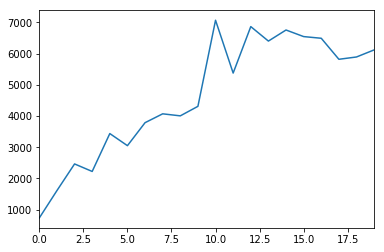

In [10]:
sales_by_month['id']['count'].plot()

In [11]:
fourier_all = np.abs(np.fft.rfft(sales_by_month['id']['count']))
fourier_all

array([93011.        , 22779.00867959,  5561.92498433,  6572.24643133,
        3130.26267431,  5439.14377453,  2687.76905048,  6240.10341329,
        3080.06941315,  5305.23042029,  1979.        ])

<BarContainer object of 11 artists>

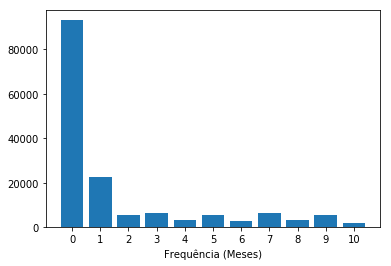

In [12]:
plt.xticks(range(len(fourier_all)))
plt.xlabel("Frequência (Meses)")
plt.bar(range(len(fourier_all)), fourier_all)

Assim como na análise anterior, pode-se notar que a frequência mais relevante é 0, o que indica ausência de uma sazonalidade forte também no período dos 20 meses observados.

### Conclusão

Olhando para os gráficos gerados para as transformações de fourier dos números de pedidos nos dois anos e nos 20 meses disponíveis, percebemos que não existe nenhum tipo de sazonalidade no número de pedidos dentro de um ano ou desse período, visto que apesar de algumas frequências se destacarem, como o período de 1 mês no último gráfico, a frequência 0 é predominante.


### Problema

Como descobrimos com o Luan, a quantidade de dados (só 16 pontos, jan-ago 2017 e jan-ago 2018) usadas para essa análise foi muito pequena, de forma que o método da transformação rápida de fourier não consegue fazer uma aproximação da função que descreve a variação de compras por mês.

A alternativa levantada foi, então, usar dados diários ao invés de mensais.

## Análise por dia

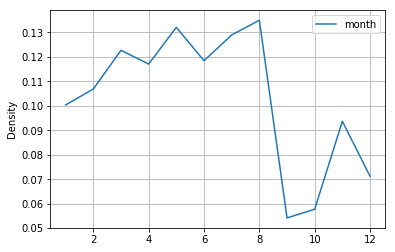

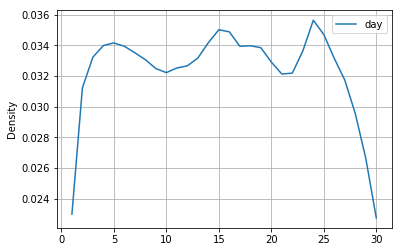

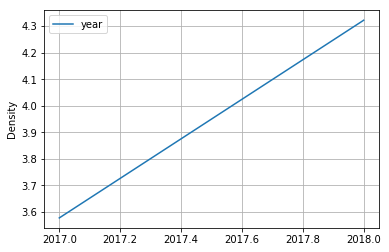

In [13]:
orders_by_year_and_month.plot.kde(y='month', ind=range(1, 13), grid=True)
orders_by_year_and_month.plot.kde(y='day', ind=range(1, 31), grid=True)
orders_by_year_and_month.plot.kde(y='year', ind=range(2017, 2019), grid=True)

### Por mês

In [50]:
orders_by_day_by_month = orders_by_year_and_month.groupby(['year', 'month'])

def histogram_for_month(m):
    days = orders_by_day_by_month.get_group(m)['day']
    return np.histogram(days, density=True, bins=range(32))[0]

monthly = [histogram_for_month(m) for m in orders_by_day_by_month.groups]
len(monthly)

20

In [51]:
def month_name(m):
    return datetime.date(1900, m % 12 + 1, 1).strftime('%B')

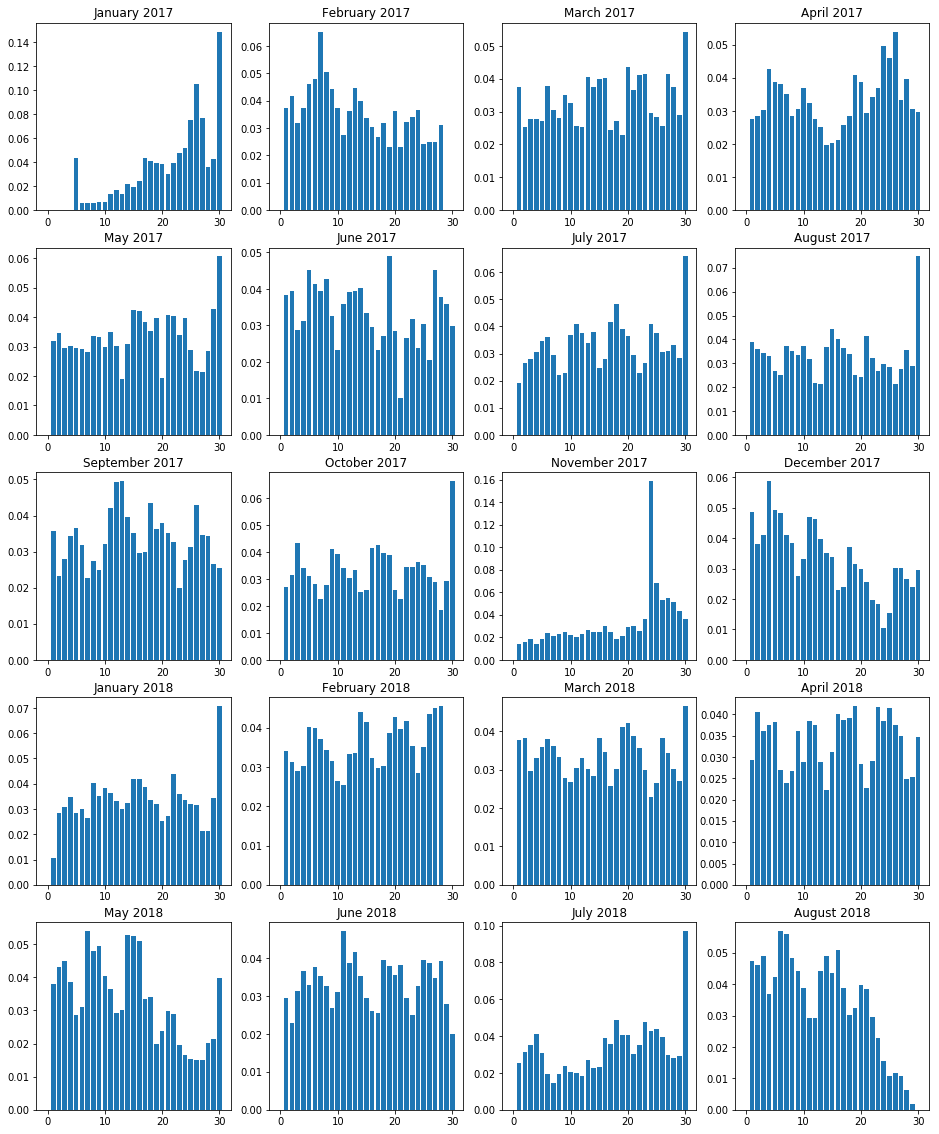

In [62]:
plt.rcParams['figure.figsize'] = (16, 20)
plt.tight_layout()

for m in range(len(monthly)):
    plt.subplot(5, 4, m + 1)
    month = monthly[m]
               
    plt.title(month_name(m) + ' ' + str(2017 + m // 12))
    plt.bar(range(len(month)), month)
    
plt.show()

In [53]:
print("P-Value:")
for m in range(len(monthly) - 12):
    month = monthly[m]
    aux_month = monthly[m + 12]
    
    pvalue = stats.kruskal(month, aux_month).pvalue
    print("\t", month_name(m), ":    \t", pvalue * 100, "%", sep='')

P-Value:
	January:    	49.004245412972416%
	February:    	79.98419637177668%
	March:    	73.54075855847017%
	April:    	84.37201218298358%
	May:    	94.38781459053033%
	June:    	81.08101883942803%
	July:    	71.43020983313252%
	August:    	26.296882868819537%


In [54]:
print(stats.kruskal(*monthly).pvalue * 100, "%", sep='')

87.47727654472787%


In [55]:
orders_by_day = orders_by_year_and_month.groupby(['year', 'month', 'day']).agg(['count']).reset_index()
orders_by_day_by_month = orders_by_day.reset_index().groupby(['year', 'month'])

months = orders_by_day_by_month.groups
months.keys()

dict_keys([(2017, 1), (2017, 2), (2017, 3), (2017, 4), (2017, 5), (2017, 6), (2017, 7), (2017, 8), (2017, 9), (2017, 10), (2017, 11), (2017, 12), (2018, 1), (2018, 2), (2018, 3), (2018, 4), (2018, 5), (2018, 6), (2018, 7), (2018, 8)])

In [20]:
def get_month(m):
    return orders_by_day_by_month.get_group(m)['id'].iloc[:, 0]

populations = [np.abs(np.fft.rfft(get_month(m).values)) for m in months]
len(populations)

20

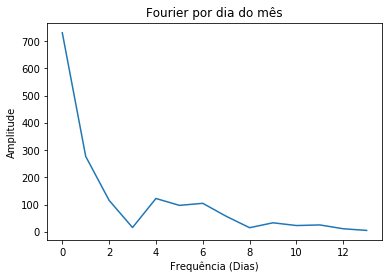

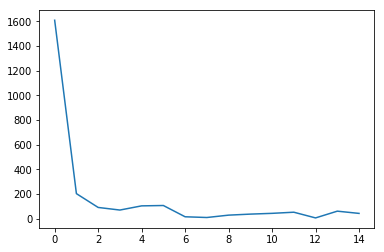

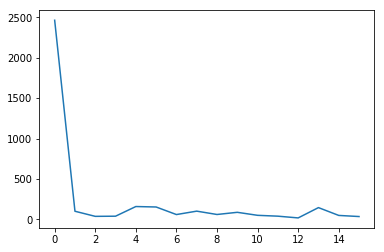

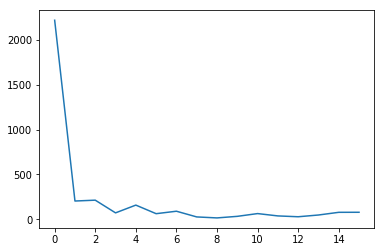

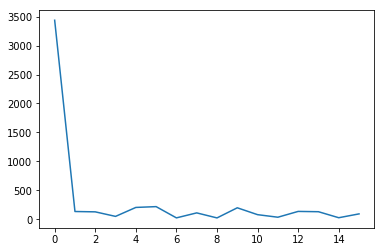

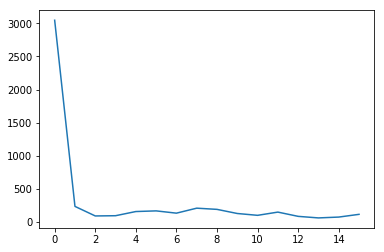

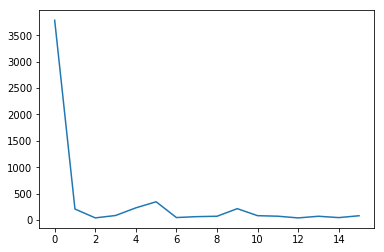

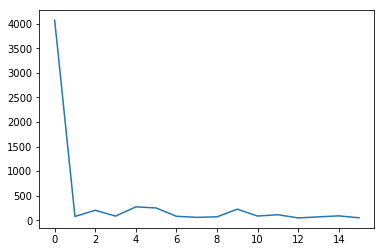

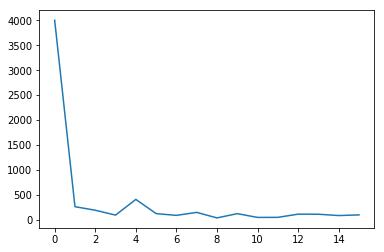

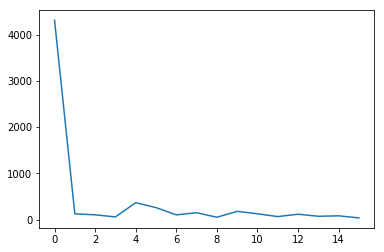

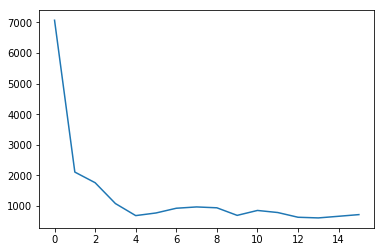

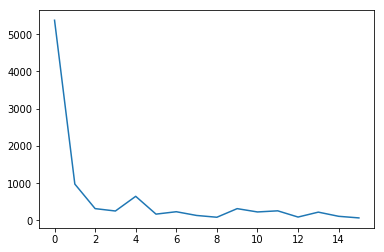

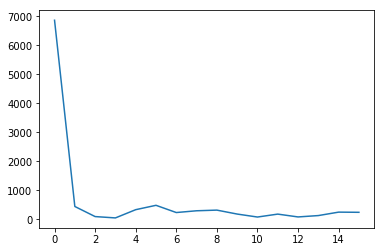

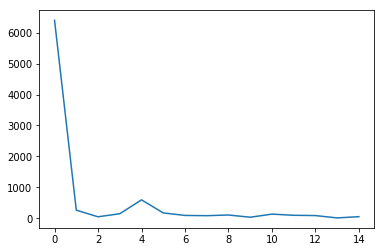

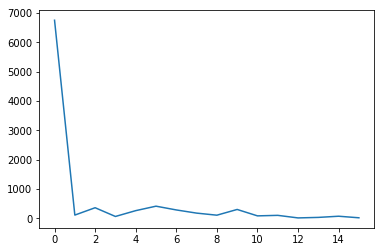

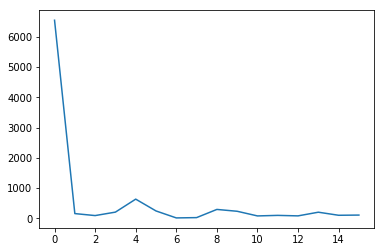

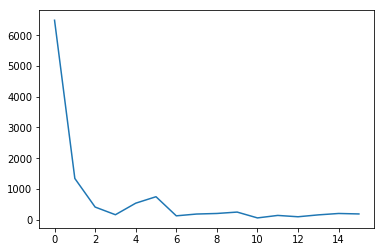

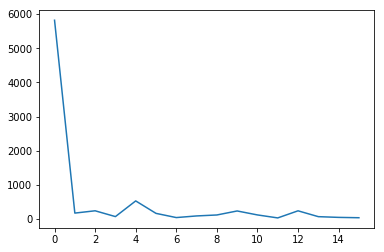

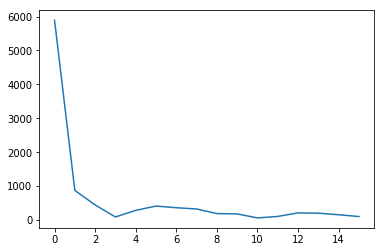

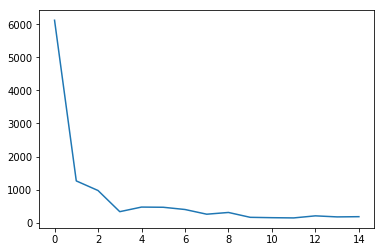

In [21]:
plt.title("Fourier por dia do mês")

plt.xlabel("Frequência (Dias)")
plt.ylabel("Amplitude")

for p in populations:
    plt.plot(p)
    plt.show()

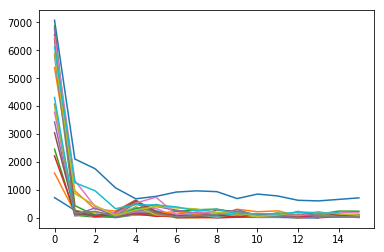

In [22]:
for p in populations:
    plt.plot(p)

In [23]:
print(stats.kruskal(*populations).pvalue * 100, "%", sep='')

6.512817473446413e-11%


In [24]:
orders_by_day_2017 = orders_by_day[
    (orders_by_day['year'] == 2017) &
    (orders_by_day['month'] <= 8)
]['id']['count']
orders_by_day_2017.count()

239

In [25]:
orders_by_day_2018 = orders_by_day[
    (orders_by_day['year'] == 2018) &
    (orders_by_day['month'] <= 8)
]['id']['count']
orders_by_day_2018.count()

241

0

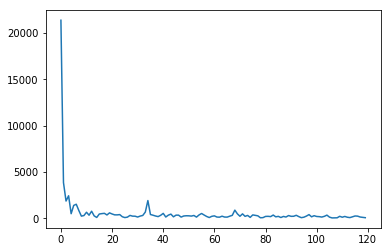

In [26]:
fourier_2017 = np.abs(np.fft.rfft(orders_by_day_2017))
plt.plot(fourier_2017)
fourier_2017.argmax()

0

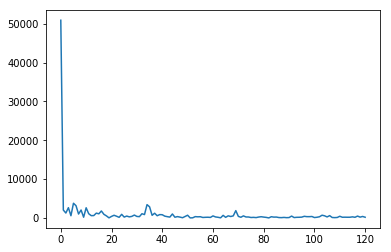

In [27]:
fourier_2018 = np.abs(np.fft.rfft(orders_by_day_2018))
plt.plot(fourier_2018)
fourier_2018.argmax()

In [28]:
print(orders_by_day.reset_index()['id'].idxmax())

count    323
dtype: int64


In [29]:
print(stats.kruskal(fourier_2017, fourier_2018).pvalue * 100, '%', sep='')

0.2366224117296674%
